<h1 style="margin-bottom:0"><center>DI 504 Project Codebase</center></h1>
<h3 style="margin-top:0"><center>Ali Yiğit Başaran - 2231355</center></h3>


In [1]:
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns



c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [93]:
# Load data
data = pd.read_excel('tumhisse.xlsm')
features = ['Date','Closing Price in TL', 'Minimum Price in TL', 'Maximum Price in TL',
            'Weighted Average Price in TL', 'Volume in TL', 'Capital in million TL',
            'USDTRY', 'BIST 100', 'Market Value in million TL', 'Market Value in million USD',
            'Public Market Value in million TL', 'Public Market Value in million USD']

## Calculation of RSI and EMA Indicators

In [94]:
import numpy as np

# Calculate the Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

# Calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Apply the calculations
data['EMA'] = calculate_ema(data['Closing Price in TL'], window=14)
data['RSI'] = calculate_rsi(data['Closing Price in TL'], window=14)

# Display the first few rows to verify the calculations
data.head()


,Date,Closing Price in TL,Minimum Price in TL,Maximum Price in TL,Weighted Average Price in TL,Volume in TL,Capital in million TL,USDTRY,BIST 100,Market Value in million TL,Market Value in million USD,Public Market Value in million TL,Public Market Value in million USD,EMA,RSI
0,02-01-2020,14.84,14.48,14.84,14.67,1627933804,1380,5.9585,1159,20479,3437,10111,1697,14.840000,NaN
1,03-01-2020,14.26,14.09,14.73,14.36,2263145825,1380,5.9734,1137,19679,3294,9715,1626,14.762667,0.000000
2,06-01-2020,13.53,13.50,14.08,13.77,1934372869,1380,5.9766,1114,18671,3124,9218,1542,14.598311,0.000000
3,07-01-2020,13.55,13.52,13.86,13.68,2226157083,1380,5.9701,1126,18699,3132,9232,1546,14.458536,1.503759
4,08-01-2020,13.50,13.03,13.62,13.43,2700201134,1380,5.9679,1129,18630,3122,9198,1541,14.330731,1.449275


## Filling NaN's in RSI

In [95]:
# Fill NA values with the first non-zero RSI value found
first_non_zero_rsi = data['RSI'][3]
data['RSI'].replace(0, first_non_zero_rsi, inplace=True)
data['RSI'].fillna(first_non_zero_rsi, inplace=True)

# Verify the changes
data.head(10)

,Date,Closing Price in TL,Minimum Price in TL,Maximum Price in TL,Weighted Average Price in TL,Volume in TL,Capital in million TL,USDTRY,BIST 100,Market Value in million TL,Market Value in million USD,Public Market Value in million TL,Public Market Value in million USD,EMA,RSI
0,02-01-2020,14.84,14.48,14.84,14.67,1627933804,1380,5.9585,1159,20479,3437,10111,1697,14.840000,1.503759
1,03-01-2020,14.26,14.09,14.73,14.36,2263145825,1380,5.9734,1137,19679,3294,9715,1626,14.762667,1.503759
2,06-01-2020,13.53,13.50,14.08,13.77,1934372869,1380,5.9766,1114,18671,3124,9218,1542,14.598311,1.503759
3,07-01-2020,13.55,13.52,13.86,13.68,2226157083,1380,5.9701,1126,18699,3132,9232,1546,14.458536,1.503759
4,08-01-2020,13.50,13.03,13.62,13.43,2700201134,1380,5.9679,1129,18630,3122,9198,1541,14.330731,1.449275
5,09-01-2020,14.25,13.92,14.28,14.11,2537765127,1380,5.8916,1180,19665,3338,9709,1648,14.319967,36.150235
6,10-01-2020,14.40,14.17,14.44,14.29,2311964645,1380,5.8819,1187,19872,3379,9811,1668,14.330638,40.350877
7,13-01-2020,14.84,14.47,14.86,14.70,2473672531,1380,5.8635,1202,20479,3493,10111,1724,14.398553,50.000000
8,14-01-2020,14.80,14.71,14.94,14.82,2510406980,1380,5.8917,1214,20424,3467,10083,1711,14.452079,49.275362
9,15-01-2020,14.70,14.61,14.89,14.74,2063892128,1380,5.8933,1209,20286,3442,10015,1699,14.485136,47.552448


# Checking NaN's or zero values

In [96]:
# Check for NaN and zero values in the dataset

# Function to check for NaN and zero values in each column
def check_data_quality(data):
    data_info = {}
    for column in data.columns:
        length = len(data[column])
        num_nan = data[column].isna().sum()
        num_zero = (data[column] == 0).sum()
        data_info[column] = {'Length': length, 'NaN Count': num_nan, 'Zero Count': num_zero}
    return pd.DataFrame(data_info).T

# Check data quality
data_quality = check_data_quality(data)
data_quality

,Length,NaN Count,Zero Count
Date,1073,0,0
Closing Price in TL,1073,0,0
Minimum Price in TL,1073,0,0
Maximum Price in TL,1073,0,0
Weighted Average Price in TL,1073,0,0
Volume in TL,1073,0,0
Capital in million TL,1073,0,0
USDTRY,1073,0,0
BIST 100,1073,0,0
Market Value in million TL,1073,0,0


# Descriptive Statistics

In [97]:
# Generate descriptive statistics
descriptive_stats = data.describe()
descriptive_stats

,Closing Price in TL,Minimum Price in TL,Maximum Price in TL,Weighted Average Price in TL,Volume in TL,Capital in million TL,USDTRY,BIST 100,Market Value in million TL,Market Value in million USD,Public Market Value in million TL,Public Market Value in million USD,EMA,RSI
count,1073.000000,1073.000000,1073.000000,1073.000000,1.073000e+03,1073.0,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,83.221650,81.826375,84.725098,83.348891,4.509340e+09,1380.0,15.240557,3390.912395,114845.875116,5549.611370,57890.443616,2795.946878,81.513030,57.012483
std,91.913256,90.526237,93.476834,92.048421,3.973257e+09,0.0,8.106711,2604.629153,126840.293526,4040.092228,63958.454288,2037.701733,90.314947,19.351946
min,7.710000,7.410000,7.950000,7.750000,1.810818e+08,1380.0,5.863500,842.000000,10640.000000,1496.000000,5251.000000,753.000000,9.000408,1.449275
25%,12.680000,12.560000,12.860000,12.710000,1.099978e+09,1380.0,7.816600,1386.000000,17498.000000,2187.000000,8812.000000,1104.000000,12.662826,42.780749
50%,28.080000,27.640000,28.500000,28.050000,3.339500e+09,1380.0,14.064800,2043.000000,38750.000000,3221.000000,19592.000000,1586.000000,27.291725,57.474227
75%,138.700000,135.500000,142.300000,139.260000,7.173402e+09,1380.0,19.035700,5115.000000,191406.000000,10033.000000,96488.000000,5048.000000,138.553849,71.449704
max,310.000000,308.500000,312.750000,309.810000,2.358628e+10,1380.0,32.415100,9814.000000,427800.000000,13635.000000,215825.000000,6870.000000,296.893656,99.316629


# Boxplots

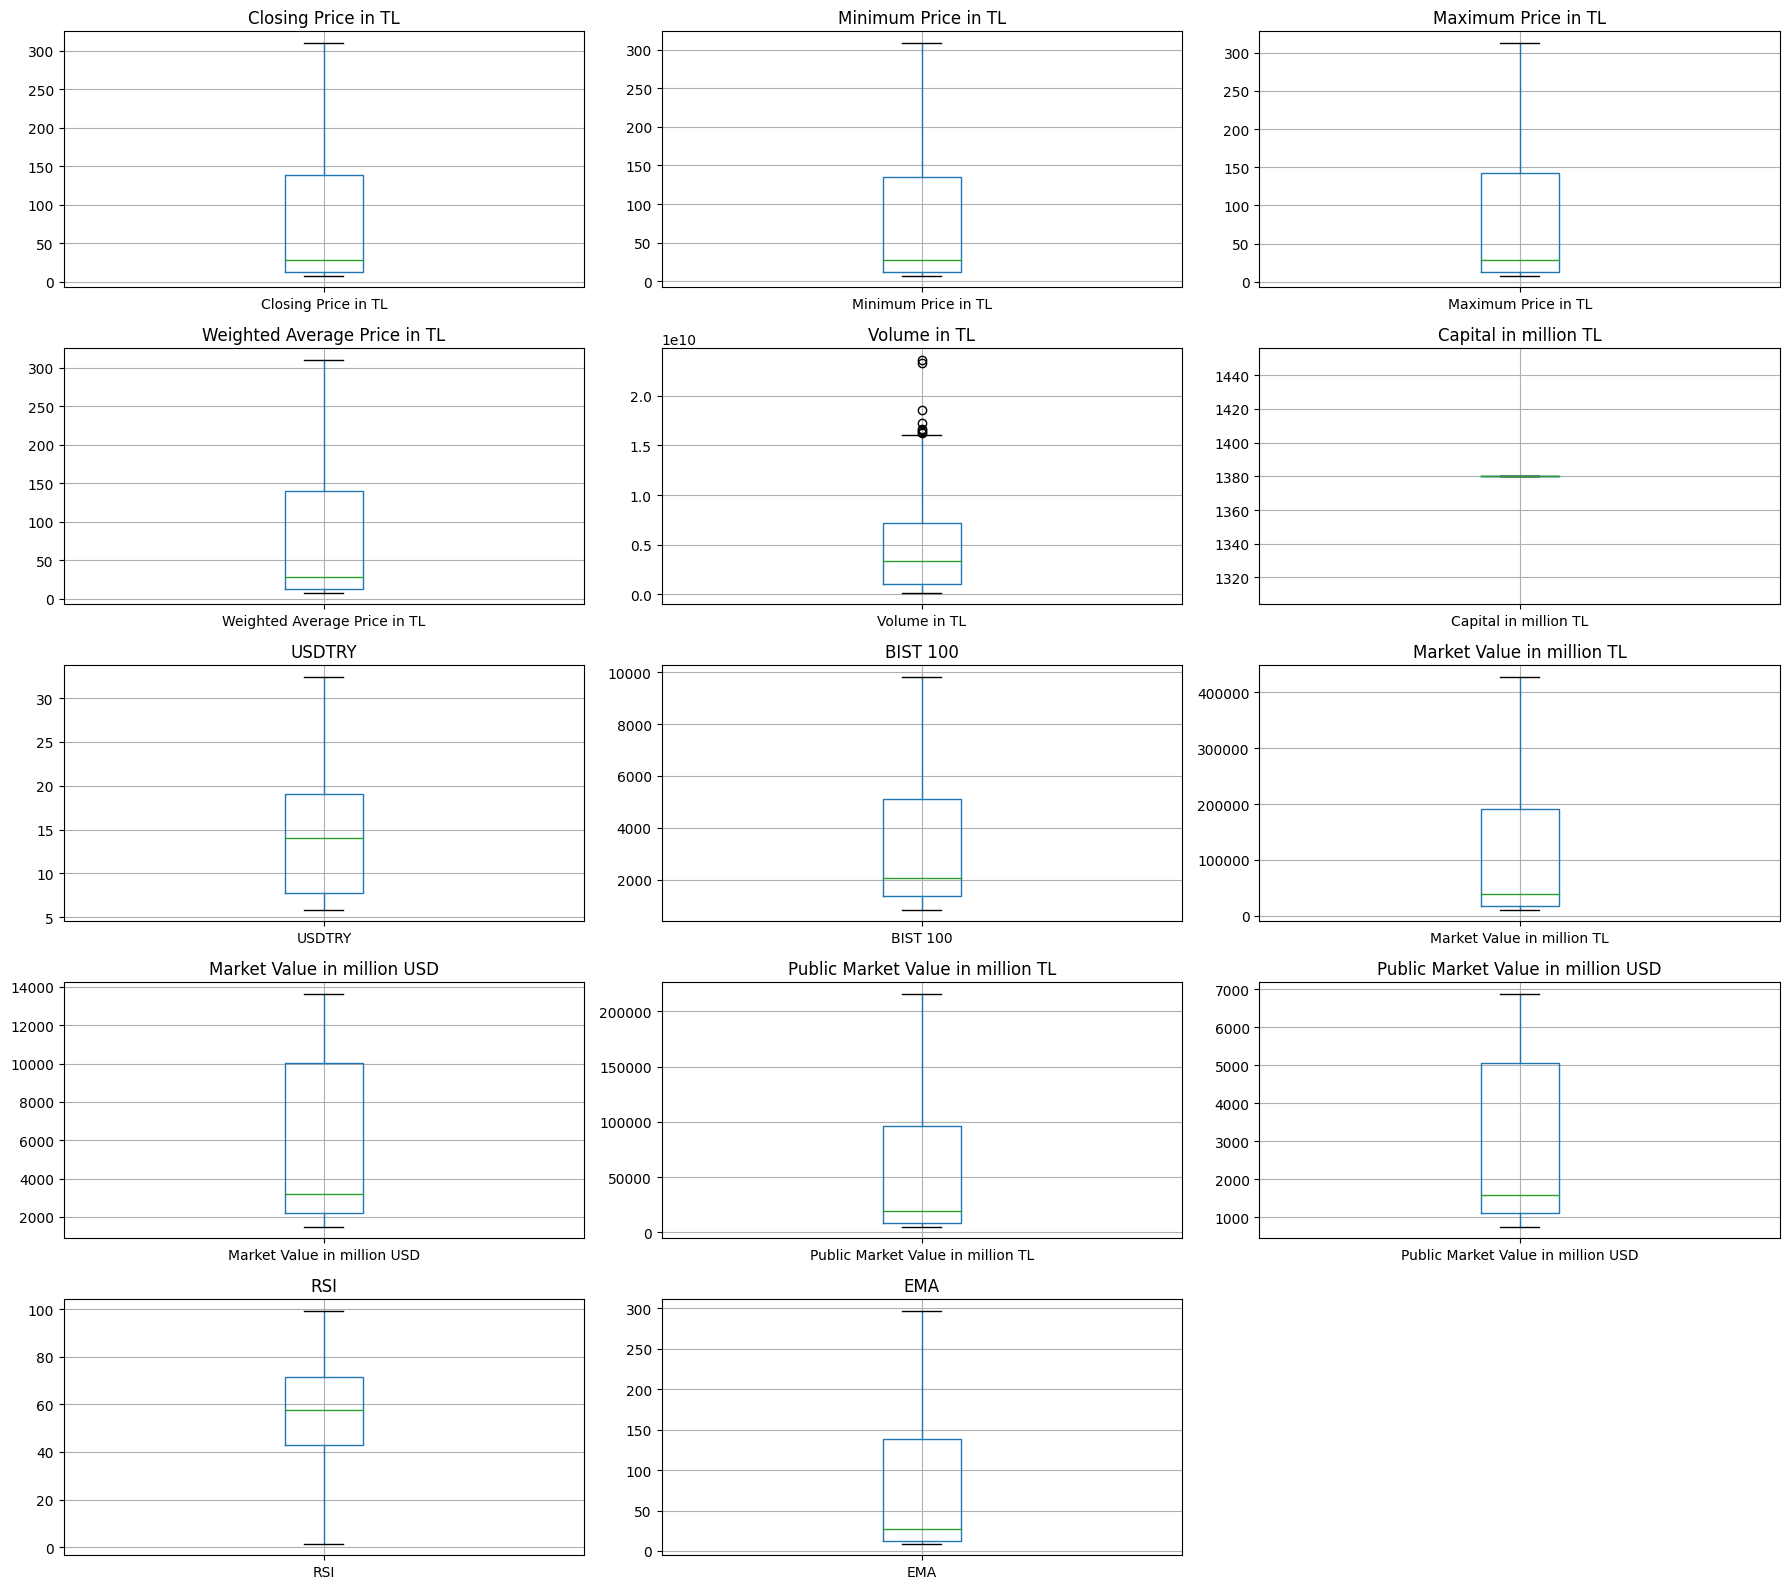

In [98]:
# Create subplots for boxplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 16))

# Define features to plot
features = ['Closing Price in TL', 'Minimum Price in TL', 'Maximum Price in TL',
            'Weighted Average Price in TL', 'Volume in TL', 'Capital in million TL',
            'USDTRY', 'BIST 100', 'Market Value in million TL', 'Market Value in million USD',
            'Public Market Value in million TL', 'Public Market Value in million USD', 'RSI', 'EMA']

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    data.boxplot(column=[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)
# Remove the last (empty) subplot
fig.delaxes(axes[4, 2])  # Remove the subplot at the 5th row, 3rd column
# Adjust layout
plt.tight_layout()
plt.show()

# Extracting cyclic features of datetime data and deleting original column

In [99]:
# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Sort the data by date
data = data.sort_values(by='Date')

# Extract date features
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Cyclic encoding for day of the week
data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Cyclic encoding for month
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Add a unique day identifier
data['DayNumber'] = (data['Date'] - data['Date'].min()).dt.days


# Retain the original Date column for reference
data_with_date = data.copy()

# Drop the original date and categorical date features
data = data.drop(columns=['Date', 'DayOfWeek', 'Month', 'Year', 'Day'])


# Feature Importance

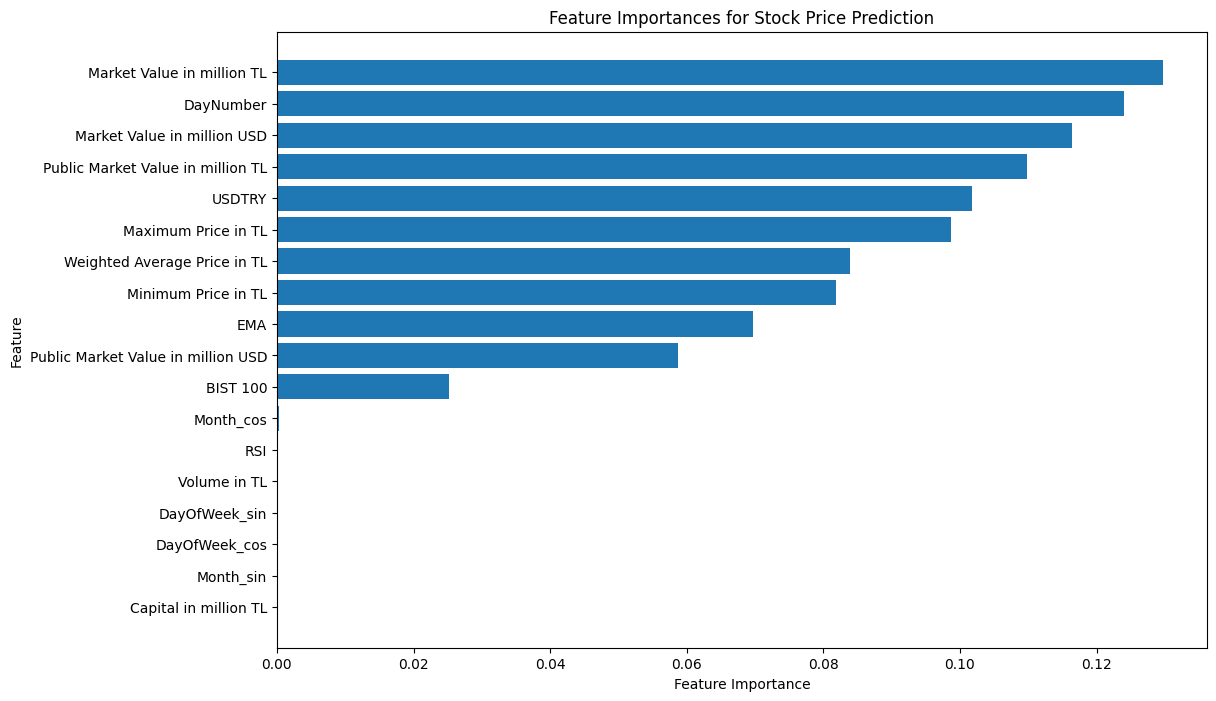

,Feature,Importance
7,Market Value in million TL,0.129674
17,DayNumber,0.123959
8,Market Value in million USD,0.116351
9,Public Market Value in million TL,0.109802
5,USDTRY,0.101785
1,Maximum Price in TL,0.098715
2,Weighted Average Price in TL,0.083896
0,Minimum Price in TL,0.081896
11,EMA,0.069712
10,Public Market Value in million USD,0.058773


In [100]:


# Prepare the data
X_features = data.drop(columns=['Closing Price in TL'])
y_target = data['Closing Price in TL']

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_features, y_target)

# Extract feature importances
importances = rf_model.feature_importances_
feature_names = X_features.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Stock Price Prediction')
plt.gca().invert_yaxis()
plt.show()

# Display the feature importances
feature_importance_df

# Correlation Matrix

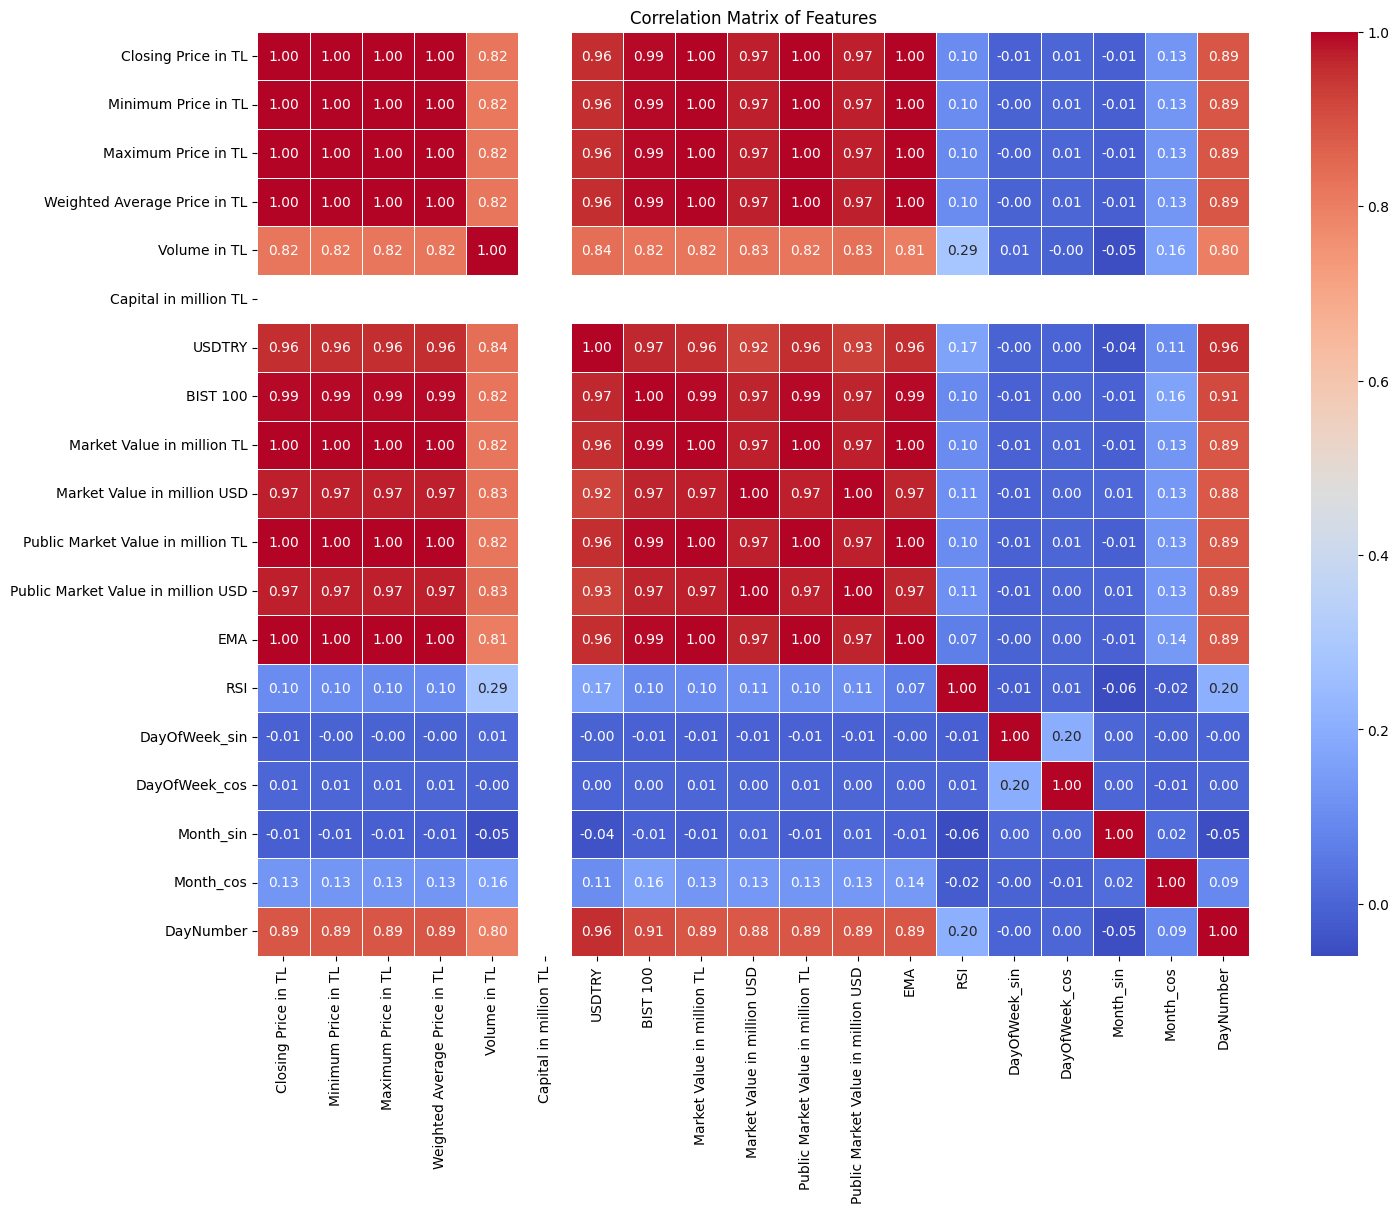

In [101]:

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Display the correlation matrix
correlation_matrix
# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Dropping not-related and interdependent features & PCA

In [102]:
from sklearn.decomposition import PCA

# Define the number of principal components
n_components = 4

data.drop(columns=['Market Value in million USD', 'Public Market Value in million USD', 'Minimum Price in TL', 'Maximum Price in TL', 'Volume in TL', 'DayOfWeek_cos', 'DayOfWeek_sin', 'Capital in million TL', 'Month_sin'], inplace=True)

# Prepare the data
X_features = data.drop(columns=['Closing Price in TL'])
y_target = data['Closing Price in TL']

# Perform PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_features)

# Create a DataFrame with the principal components
pca_columns = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Add the target variable back to the DataFrame
X_pca_df['Closing Price in TL'] = y_target.values

# Display the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

# Display the first few rows of the DataFrame with principal components
X_pca_df.head()

,PC1,PC2,PC3,PC4,Closing Price in TL
0,-105798.052212,529.900760,56.146916,-271.560031,14.84
1,-106690.919456,531.532657,48.915196,-265.751468,14.26
2,-107814.959132,528.369351,39.258122,-259.240556,13.53
3,-107783.438402,518.284212,41.821910,-264.044002,13.55
4,-107860.286846,513.812066,42.173171,-265.148358,13.50


# Creating Sequence Data w/window size = 5 & Splitting Training-Validation-Test Data & MinMax Normaliztion

In [103]:
# Define the window size
window_size = 5

# Function to create sequences
def create_sequences(data, target_col, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequence = data.iloc[i:i + window_size].values
        target = data.iloc[i + window_size][target_col]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Prepare the data for sequence creation
target_col = 'Closing Price in TL'
sequences, targets = create_sequences(X_pca_df, target_col, window_size)

# Split the data into training, validation, and test sets
train_size = int(len(sequences) * 0.7)
val_size = int(len(sequences) * 0.2)
test_size = len(sequences) - train_size - val_size

X_train = sequences[:train_size]
y_train = targets[:train_size]

X_val = sequences[train_size:train_size + val_size]
y_val = targets[train_size:train_size + val_size]

X_test = sequences[train_size + val_size:]
y_test = targets[train_size + val_size:]

# Reshape X data to 2D for scaling
n_train_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(n_train_samples * n_timesteps, n_features)

n_val_samples = X_val.shape[0]
X_val_reshaped = X_val.reshape(n_val_samples * n_timesteps, n_features)

n_test_samples = X_test.shape[0]
X_test_reshaped = X_test.reshape(n_test_samples * n_timesteps, n_features)

# Input and Target Scalers (MinMax)
input_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scalers
input_scaler.fit(X_train_reshaped)
target_scaler.fit(y_train.reshape(-1, 1))

# Transform the data
X_train = input_scaler.transform(X_train_reshaped).reshape(n_train_samples, n_timesteps, n_features)
X_val = input_scaler.transform(X_val_reshaped).reshape(n_val_samples, n_timesteps, n_features)
X_test = input_scaler.transform(X_test_reshaped).reshape(n_test_samples, n_timesteps, n_features)

y_train = target_scaler.transform(y_train.reshape(-1, 1))
y_val = target_scaler.transform(y_val.reshape(-1, 1))
y_test = target_scaler.transform(y_test.reshape(-1, 1))

# Display the shapes of the datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (747, 5, 5), (747, 1)
Validation set: (213, 5, 5), (213, 1)
Test set: (108, 5, 5), (108, 1)


# Training and Validating LSTM (Baseline) Model with Optuna

In [126]:
#LSTM

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_lstm_units = trial.suggest_int('n_lstm_units', 50, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_layers = trial.suggest_int('n_layers', 1, 2)
    batch_size = trial.suggest_int('batch_size', 32, 64)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-3)


    # Build the LSTM model
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(LSTM(n_lstm_units, return_sequences=(i < n_layers - 1), input_shape=(window_size, X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        else:
            model.add(LSTM(n_lstm_units, return_sequences=(i < n_layers - 1), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, reduce_lr])

    # Evaluate the model on the validation set
    val_loss = model.evaluate(X_val, y_val, verbose=1)
    return val_loss[0]

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters
print(f"Best hyperparameters: {best_trial.params}")

# Train the final model with the best hyperparameters
best_params = best_trial.params
best_model = Sequential()
for i in range(best_params['n_layers']):
    if i == 0:
        best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=(i < best_params['n_layers'] - 1), input_shape=(window_size, X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])))
    else:
        best_model.add(LSTM(best_params['n_lstm_units'], return_sequences=(i < best_params['n_layers'] - 1), kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1))

# Compile the final model
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

# Train the final model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, y_val))



[I 2024-06-10 19:27:42,323] A new study created in memory with name: no-name-f3a543be-b84f-492e-a103-13124cbcd774


Num GPUs Available:  1


<ipython-input-126-fdc7987dbb54>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-126-fdc7987dbb54>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-3)


Epoch 1/50
16/16 [==============================] - 7s 57ms/step - loss: 0.2035 - mean_absolute_error: 0.1756 - root_mean_squared_error: 0.2739 - val_loss: 1.6089 - val_mean_absolute_error: 1.1713 - val_root_mean_squared_error: 1.2178 - lr: 1.2392e-04
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1760 - mean_absolute_error: 0.1207 - root_mean_squared_error: 0.2283 - val_loss: 1.3249 - val_mean_absolute_error: 1.0492 - val_root_mean_squared_error: 1.0970 - lr: 1.2392e-04
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1557 - mean_absolute_error: 0.0987 - root_mean_squared_error: 0.1903 - val_loss: 1.0610 - val_mean_absolute_error: 0.9227 - val_root_mean_squared_error: 0.9715 - lr: 1.2392e-04
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1429 - mean_absolute_error: 0.0988 - root_mean_squared_error: 0.1662 - val_loss: 0.8273 - val_mean_absolute_error: 0.7966 - val_root_mean_squared_error: 0.8452 - lr: 1.2392

[I 2024-06-10 19:27:59,588] Trial 0 finished with value: 0.0251776073127985 and parameters: {'n_lstm_units': 76, 'dropout_rate': 0.3344650969302051, 'learning_rate': 0.00012392312350936028, 'n_layers': 2, 'batch_size': 49, 'l2_reg': 0.0009933004841478877}. Best is trial 0 with value: 0.0251776073127985.


Best hyperparameters: {'n_lstm_units': 76, 'dropout_rate': 0.3344650969302051, 'learning_rate': 0.00012392312350936028, 'n_layers': 2, 'batch_size': 49, 'l2_reg': 0.0009933004841478877}
Epoch 1/50
16/16 [==============================] - 6s 89ms/step - loss: 0.2048 - mean_absolute_error: 0.1610 - root_mean_squared_error: 0.2764 - val_loss: 1.6684 - val_mean_absolute_error: 1.1963 - val_root_mean_squared_error: 1.2420
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1799 - mean_absolute_error: 0.1267 - root_mean_squared_error: 0.2369 - val_loss: 1.3278 - val_mean_absolute_error: 1.0528 - val_root_mean_squared_error: 1.0984
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.1589 - mean_absolute_error: 0.1163 - root_mean_squared_error: 0.1987 - val_loss: 1.0437 - val_mean_absolute_error: 0.9179 - val_root_mean_squared_error: 0.9626
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.1451 - mean_absolute_error: 0.1144 

# Testing on MAE and RMSE and Plotting Loss Curves of LSTM(Baseline) Model 

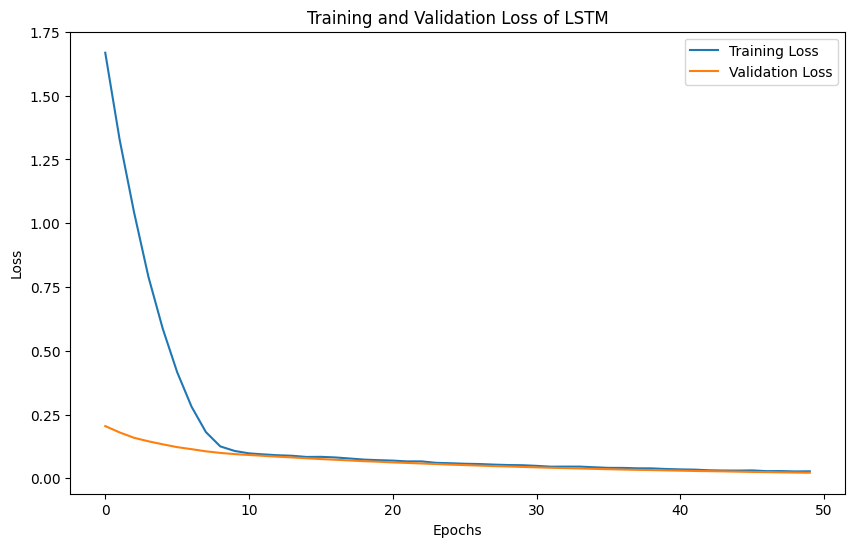

4/4 [==============================] - 0s 5ms/step - loss: 0.0423 - mean_absolute_error: 0.1319 - root_mean_squared_error: 0.1481
Test MAE: 0.13194869458675385, Test RMSE: 0.14810602366924286
Best HyperParameters of LSTM: 
 {'n_lstm_units': 76, 'dropout_rate': 0.3344650969302051, 'learning_rate': 0.00012392312350936028, 'n_layers': 2, 'batch_size': 49, 'l2_reg': 0.0009933004841478877}


In [127]:
# Plot training and validation loss of LSTM
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(np.array(history.history['loss']), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM')
plt.legend()
plt.show()

# Evaluate the final model on the test set for LSTM
test_loss, test_mae, test_rmse = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}, Test RMSE: {test_rmse}")

# Best Hyperparameters of LSTM
print(f"Best HyperParameters of LSTM: \n {best_params}")

# Training and Validating BiLSTM (Proposed) Model with Optuna

In [122]:
#BiLSTM
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_lstm_units = trial.suggest_int('n_lstm_units', 50, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_layers = trial.suggest_int('n_layers', 1, 2)
    batch_size = trial.suggest_int('batch_size', 32, 64)
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-3)

    # Build the BiLSTM model
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(Bidirectional(LSTM(n_lstm_units, return_sequences=(i < n_layers - 1), input_shape=(window_size, X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(l2_reg))))
        else:
            model.add(Bidirectional(LSTM(n_lstm_units, return_sequences=(i < n_layers - 1), kernel_regularizer=tf.keras.regularizers.l2(l2_reg))))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, reduce_lr])

    # Evaluate the model on the validation set
    val_loss = model.evaluate(X_val, y_val, verbose=1)
    return val_loss[0]

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters
print(f"Best hyperparameters: {best_trial.params}")

# Train the final model with the best hyperparameters
best_params = best_trial.params
best_model = Sequential()
for i in range(best_params['n_layers']):
    if i == 0:
        best_model.add(Bidirectional(LSTM(best_params['n_lstm_units'], return_sequences=(i < best_params['n_layers'] - 1), input_shape=(window_size, X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg']))))
    else:
        best_model.add(Bidirectional(LSTM(best_params['n_lstm_units'], return_sequences=(i < best_params['n_layers'] - 1), kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg']))))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1))

# Compile the final model
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

# Train the final model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, y_val))



[I 2024-06-10 19:24:51,173] A new study created in memory with name: no-name-2d09b036-8ba7-4adc-94cc-e6cec8d63fea


Num GPUs Available:  1
Epoch 1/50


<ipython-input-122-93b158e0f891>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-122-93b158e0f891>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-3)


13/13 [==============================] - 6s 68ms/step - loss: 0.1278 - mean_absolute_error: 0.2214 - root_mean_squared_error: 0.3565 - val_loss: 2.3268 - val_mean_absolute_error: 1.4785 - val_root_mean_squared_error: 1.5252 - lr: 2.9145e-05
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 0.1172 - mean_absolute_error: 0.2116 - root_mean_squared_error: 0.3413 - val_loss: 2.2312 - val_mean_absolute_error: 1.4467 - val_root_mean_squared_error: 1.4935 - lr: 2.9145e-05
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1110 - mean_absolute_error: 0.2041 - root_mean_squared_error: 0.3321 - val_loss: 2.1368 - val_mean_absolute_error: 1.4147 - val_root_mean_squared_error: 1.4616 - lr: 2.9145e-05
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1018 - mean_absolute_error: 0.1970 - root_mean_squared_error: 0.3179 - val_loss: 2.0481 - val_mean_absolute_error: 1.3840 - val_root_mean_squared_error: 1.4309 - lr: 2.9145e-05
Epoch

[I 2024-06-10 19:25:05,856] Trial 0 finished with value: 0.24947921931743622 and parameters: {'n_lstm_units': 54, 'dropout_rate': 0.3423720581874058, 'learning_rate': 2.9144678526980253e-05, 'n_layers': 1, 'batch_size': 58, 'l2_reg': 3.7131876332893974e-05}. Best is trial 0 with value: 0.24947921931743622.


Epoch 1/50
16/16 [==============================] - 9s 99ms/step - loss: 0.0473 - mean_absolute_error: 0.1170 - root_mean_squared_error: 0.2049 - val_loss: 0.4466 - val_mean_absolute_error: 0.6202 - val_root_mean_squared_error: 0.6644 - lr: 2.8351e-04
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0187 - mean_absolute_error: 0.0925 - root_mean_squared_error: 0.1161 - val_loss: 0.0979 - val_mean_absolute_error: 0.2776 - val_root_mean_squared_error: 0.3046 - lr: 2.8351e-04
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0088 - mean_absolute_error: 0.0416 - root_mean_squared_error: 0.0611 - val_loss: 0.0081 - val_mean_absolute_error: 0.0433 - val_root_mean_squared_error: 0.0559 - lr: 2.8351e-04
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0072 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0481 - val_loss: 0.0108 - val_mean_absolute_error: 0.0645 - val_root_mean_squared_error: 0.0776 - lr: 2.8

[I 2024-06-10 19:25:21,490] Trial 1 finished with value: 0.00620063254609704 and parameters: {'n_lstm_units': 68, 'dropout_rate': 0.433929155981289, 'learning_rate': 0.0002835069292865666, 'n_layers': 2, 'batch_size': 49, 'l2_reg': 1.3939219184664843e-05}. Best is trial 1 with value: 0.00620063254609704.


Epoch 1/50
13/13 [==============================] - 7s 72ms/step - loss: 0.0676 - mean_absolute_error: 0.1488 - root_mean_squared_error: 0.2575 - val_loss: 1.3936 - val_mean_absolute_error: 1.1292 - val_root_mean_squared_error: 1.1800 - lr: 1.3767e-04
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0499 - mean_absolute_error: 0.1407 - root_mean_squared_error: 0.2204 - val_loss: 1.0707 - val_mean_absolute_error: 0.9834 - val_root_mean_squared_error: 1.0341 - lr: 1.3767e-04
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0405 - mean_absolute_error: 0.1355 - root_mean_squared_error: 0.1981 - val_loss: 0.8267 - val_mean_absolute_error: 0.8592 - val_root_mean_squared_error: 0.9085 - lr: 1.3767e-04
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0330 - mean_absolute_error: 0.1241 - root_mean_squared_error: 0.1780 - val_loss: 0.6436 - val_mean_absolute_error: 0.7552 - val_root_mean_squared_error: 0.8015 - lr: 1.3767

[I 2024-06-10 19:25:32,485] Trial 2 finished with value: 0.004311015829443932 and parameters: {'n_lstm_units': 68, 'dropout_rate': 0.33605184057256393, 'learning_rate': 0.0001376691543837264, 'n_layers': 1, 'batch_size': 60, 'l2_reg': 6.521209488758997e-05}. Best is trial 2 with value: 0.004311015829443932.


Epoch 1/50
21/21 [==============================] - 6s 44ms/step - loss: 0.0723 - mean_absolute_error: 0.1556 - root_mean_squared_error: 0.2684 - val_loss: 1.5646 - val_mean_absolute_error: 1.2022 - val_root_mean_squared_error: 1.2507 - lr: 4.1282e-05
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0603 - mean_absolute_error: 0.1349 - root_mean_squared_error: 0.2448 - val_loss: 1.3769 - val_mean_absolute_error: 1.1248 - val_root_mean_squared_error: 1.1733 - lr: 4.1282e-05
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0507 - mean_absolute_error: 0.1269 - root_mean_squared_error: 0.2244 - val_loss: 1.2058 - val_mean_absolute_error: 1.0495 - val_root_mean_squared_error: 1.0979 - lr: 4.1282e-05
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0438 - mean_absolute_error: 0.1207 - root_mean_squared_error: 0.2085 - val_loss: 1.0579 - val_mean_absolute_error: 0.9801 - val_root_mean_squared_error: 1.0284 - lr: 4.1282

[I 2024-06-10 19:25:47,218] Trial 3 finished with value: 0.004592742305248976 and parameters: {'n_lstm_units': 77, 'dropout_rate': 0.4333042914386731, 'learning_rate': 4.12817771746884e-05, 'n_layers': 1, 'batch_size': 37, 'l2_reg': 1.5132255287509047e-05}. Best is trial 2 with value: 0.004311015829443932.


Epoch 1/50
24/24 [==============================] - 10s 68ms/step - loss: 0.0403 - mean_absolute_error: 0.1058 - root_mean_squared_error: 0.1630 - val_loss: 0.0689 - val_mean_absolute_error: 0.2174 - val_root_mean_squared_error: 0.2366 - lr: 5.6066e-04
Epoch 2/50
24/24 [==============================] - 0s 11ms/step - loss: 0.0143 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0472 - val_loss: 0.0155 - val_mean_absolute_error: 0.0517 - val_root_mean_squared_error: 0.0654 - lr: 5.6066e-04
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0123 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0423 - val_loss: 0.0160 - val_mean_absolute_error: 0.0608 - val_root_mean_squared_error: 0.0793 - lr: 5.6066e-04
Epoch 4/50
24/24 [==============================] - 0s 15ms/step - loss: 0.0105 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0374 - val_loss: 0.0145 - val_mean_absolute_error: 0.0601 - val_root_mean_squared_error: 0.0783 - lr: 5.

[I 2024-06-10 19:26:04,852] Trial 4 finished with value: 0.009587938897311687 and parameters: {'n_lstm_units': 58, 'dropout_rate': 0.36183797273823065, 'learning_rate': 0.000560660782932084, 'n_layers': 2, 'batch_size': 32, 'l2_reg': 4.369884908353089e-05}. Best is trial 2 with value: 0.004311015829443932.


Best hyperparameters: {'n_lstm_units': 68, 'dropout_rate': 0.33605184057256393, 'learning_rate': 0.0001376691543837264, 'n_layers': 1, 'batch_size': 60, 'l2_reg': 6.521209488758997e-05}
Epoch 1/50
13/13 [==============================] - 4s 69ms/step - loss: 0.0421 - mean_absolute_error: 0.1207 - root_mean_squared_error: 0.2022 - val_loss: 0.7170 - val_mean_absolute_error: 0.8082 - val_root_mean_squared_error: 0.8460
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0274 - mean_absolute_error: 0.1125 - root_mean_squared_error: 0.1618 - val_loss: 0.4747 - val_mean_absolute_error: 0.6507 - val_root_mean_squared_error: 0.6881
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.1021 - root_mean_squared_error: 0.1411 - val_loss: 0.3234 - val_mean_absolute_error: 0.5330 - val_root_mean_squared_error: 0.5676
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0146 - mean_absolute_error: 0.0856 - 

# Testing on MAE and RMSE and Plotting Loss Curves of BiLSTM(Proposed) Model 

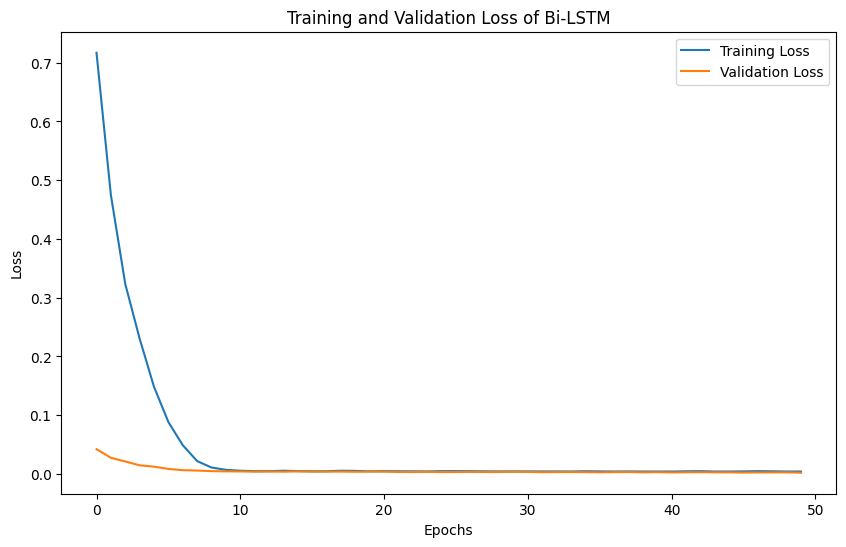

4/4 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_error: 0.0582 - root_mean_squared_error: 0.0729
Test MAE: 0.05821988731622696, Test RMSE: 0.072866290807724
Best HyperParameters of Bi-LSTM: 
 {'n_lstm_units': 68, 'dropout_rate': 0.33605184057256393, 'learning_rate': 0.0001376691543837264, 'n_layers': 1, 'batch_size': 60, 'l2_reg': 6.521209488758997e-05}


In [123]:
# Plot training and validation loss of Bi-LSTM
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(np.array(history.history['loss']), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of Bi-LSTM')
plt.legend()
plt.show()

# Evaluate the final model on the test set for Bi-LSTM
test_loss, test_mae, test_rmse = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}, Test RMSE: {test_rmse}")

# Best Hyperparameters of LSTM
print(f"Best HyperParameters of Bi-LSTM: \n {best_params}")